# Importing required libraries

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [1]:
import pandas as pd
import numpy as np
from glob import glob
import re
import json
import sys

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
#import stemmer as hindi_stemmer

In [3]:
english_stopwords = stopwords.words("english")

with open('final_stopwords.txt', encoding='utf-8') as f:
    hindi_stopwords = f.readlines()
    for i in range(len(hindi_stopwords)):
        hindi_stopwords[i] = re.sub('\n', '', hindi_stopwords[i])

stopword = english_stopwords + hindi_stopwords
english_stemmer = SnowballStemmer("english")

In [4]:
train_directories = []
for i in glob("/kaggle/input/marathi/testdata/train/*/*/"):
    for j in glob(i+'*/'):
        train_directories.append(j)

In [5]:
train_directories

[]

In [6]:
words_dict  = { "तैराक":"तैर",
                "चालाक":"चाल",
                "कूलाक":"कूल",
                "बेलन":"बेल",
                "मिलाप":"मिल",
                "चुपचाप": "चुप",
                "निकास":"निकस",
                "लुकास":"लुक",
                }

In [7]:
data = []
for i in train_directories:
    try:
        with open(i+'data.json', encoding='utf-8') as f:
            data.append(json.load(f))
    except:
        continue

binary_labels = []
for i in train_directories:
    if('Hinglish' in i):
        with open(i+'binary_labels.json', encoding='utf-8') as f:
            binary_labels.append(json.load(f))
    else:
        try:
            with open(i+'labels.json', encoding='utf-8') as f:
                binary_labels.append(json.load(f))
        except:
            continue

In [8]:
def tr_flatten(d,l):
    flat_text = []
    flat_text.append({
        'tweet_id':d['tweet_id'],
        'text':d['tweet'],
        'label':l[d['tweet_id']]
    })

    for i in d['comments']:
            flat_text.append({
                'tweet_id':i['tweet_id'],
                'text':flat_text[0]['text'] +' '+i['tweet'], 
                'label':l[i['tweet_id']]
            })
            if 'replies' in i.keys():
                for j in i['replies']:
                    flat_text.append({
                        'tweet_id':j['tweet_id'],
                        'text':flat_text[0]['text'] +' '+ i['tweet'] +' '+ j['tweet'], 
                        'label':l[j['tweet_id']]
                    })
    return flat_text

def te_flatten(d):
    flat_text = []
    flat_text.append({
        'tweet_id':d['tweet_id'],
        'text':d['tweet'],
    })

    for i in d['comments']:
            flat_text.append({
                'tweet_id':i['tweet_id'],
                'text':flat_text[0]['text'] + i['tweet'],
            })
            if 'replies' in i.keys():
                for j in i['replies']:
                    flat_text.append({
                        'tweet_id':j['tweet_id'],
                        'text':flat_text[0]['text'] + i['tweet'] + j['tweet'],
                    })
    return flat_text

In [36]:
data_label = []
#for train
for i in range(len(binary_labels)):
    for j in tr_flatten(data[i], binary_labels[i]):
        data_label.append(j)
train_len = len(data_label)

In [37]:
df = pd.DataFrame(data_label, columns = data_label[0].keys(), index = None)

IndexError: list index out of range

In [ ]:
df.head()

NameError: name 'df' is not defined

In [ ]:
df.loc[df['label'] == 'NONE'] = 'NOT'
df['label'].value_counts()

NameError: name 'df' is not defined

In [ ]:
tweets = df.text
y = df.label

In [11]:
suffixes = {
	    1: ["ो", "े", "ू", "ु", "ी", "ि", "ा"],  
            2: ["तृ","ान","ैत","ने","ाऊ","ाव","कर", "ाओ", "िए", "ाई", "ाए", "नी", "ना", "ते", "ीं", "ती",
                "ता", "ाँ", "ां", "ों", "ें","ीय", "ति","या", "पन", "पा","ित","ीन","लु","यत","वट","लू"],     
            3: ["ेरा","त्व","नीय","ौनी","ौवल","ौती","ौता","ापा","वास","हास","काल","पान","न्त","ौना","सार","पोश","नाक",
                "ियल","ैया", "ौटी","ावा","ाहट","िया","हार", "ाकर", "ाइए", "ाईं", "ाया", "ेगी", "वान", "बीन",
                "ेगा", "ोगी", "ोगे", "ाने", "ाना", "ाते", "ाती", "ाता", "तीं", "ाओं", "ाएं", "ुओं", "ुएं", "ुआं","कला","िमा","कार",
                "गार", "दान","खोर"],     
            4: ["ावास","कलाप","हारा","तव्य","वैया", "वाला", "ाएगी", "ाएगा", "ाओगी", "ाओगे", 
                "एंगी", "ेंगी", "एंगे", "ेंगे", "ूंगी", "ूंगा", "ातीं", "नाओं", "नाएं", "ताओं", "ताएं", "ियाँ", "ियों", "ियां",
                "त्वा","तव्य","कल्प","िष्ठ","जादा","क्कड़"],     
            5: ["ाएंगी", "ाएंगे", "ाऊंगी", "ाऊंगा", "ाइयाँ", "ाइयों", "ाइयां", "अक्कड़","तव्य:","निष्ठ"],
}

special_suffixes = ["र्", "ज्य","त्य"]
dict_special_suffixes = {"र्":"ृ",
                         "ज्य":"ज्",
                         "त्य":"त्"}

def hi_stem(word, clean=False,chars=None):
    if clean == True:
        word = clean_text(word, chars)
    
    ans = word
    bl = False
    
    if word in words_dict.keys():
        return words_dict[word]
    
    for L in 5, 4, 3, 2, 1:
        if len(word) > L + 1:
            for suf in suffixes[L]:
                if word.endswith(suf):
                    ans = word[:-L]
                    bl =True
        if bl == True:
            break
                    
    if bl == True:
        for suf in suffixes[1]:
            if ans.endswith(suf):
                # use case - गानेवाला
                ans = hi_stem(ans)
   
    for suf in special_suffixes:
        if ans.endswith(suf):
            l = len(suf)
            ans = ans[:-l]
            ans += dict_special_suffixes[suf]
 
    return ans

def clean_text(text, chars=None):
    if chars == None:        
        text = re.sub(r"[()\"#/@;:<>{}`+=~|!?,']", "", text)
    else:
        text = re.sub(r"[" +chars+ "()\"#/@;:<>{}`+=~|!?,']", "", text)
    return text

In [32]:
regex_for_english_hindi_emojis="[^a-zA-Z#\U0001F300-\U0001F5FF'|'\U0001F600-\U0001F64F'|'\U0001F680-\U0001F6FF'|'\u2600-\u26FF\u2700-\u27BF\u0900-\u097F]"
def clean_tweet(tweet, english_stemmer, stopword):
    tweet = re.sub(r"@[A-Za-z0-9]+", ' ', tweet)
    tweet = re.sub(r"https?://[A-Za-z0-9./]+", ' ', tweet)
    tweet = re.sub(regex_for_english_hindi_emojis, ' ', tweet)
    tweet = re.sub("RT ", " ", tweet)
    tweet = re.sub("\n", " ", tweet)
    tweet = re.sub(r" +", " ", tweet)
    tokens = []
    for token in tweet.split():
        if token not in stopword:
            token = english_stemmer.stem(token)
            token = hi_stem(token)
            tokens.append(token)
    return " ".join(tokens)

In [35]:
cleaned_tweets = [clean_tweet(
        tweet, english_stemmer, stopword) for tweet in tweets]

NameError: name 'cleaned_tweets' is not defined

In [14]:
vectorizer = TfidfVectorizer(min_df = 5)
X = vectorizer.fit_transform(cleaned_tweets)
X = X.todense()

NameError: name 'cleaned_tweets' is not defined

In [15]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=50)

NameError: name 'X' is not defined

# Logistic Regression

In [16]:
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

NameError: name 'X_train' is not defined

In [17]:
y_pred = classifier.predict(X_val)

NameError: name 'X_val' is not defined

In [18]:
print(classification_report(y_val, y_pred))

NameError: name 'y_val' is not defined

# Classifier Comparison (Comparative Analysis)

In [19]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix,f1_score,plot_roc_curve,accuracy_score,roc_curve,roc_auc_score,recall_score,log_loss

In [20]:
names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
]

In [21]:
 for name, clf in zip(names, classifiers):
        clf = make_pipeline(StandardScaler(), clf)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_val)
        print(clf)
        print(classification_report(y_val, y_pred))

NameError: name 'X_train' is not defined

# NN model

In [22]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)

NameError: name 'y_train' is not defined

In [23]:
model = Sequential(
    [
        Dense(64, activation="relu"),
        Dense(32, activation="relu"),
        Dense(16, activation="relu"),
        Dense(16, activation="relu"),
        Dense(8, activation="relu"),
        Dense(1, activation="sigmoid"),
    ]
)
model.compile('adam', loss='binary_crossentropy', metrics = ['accuracy'])

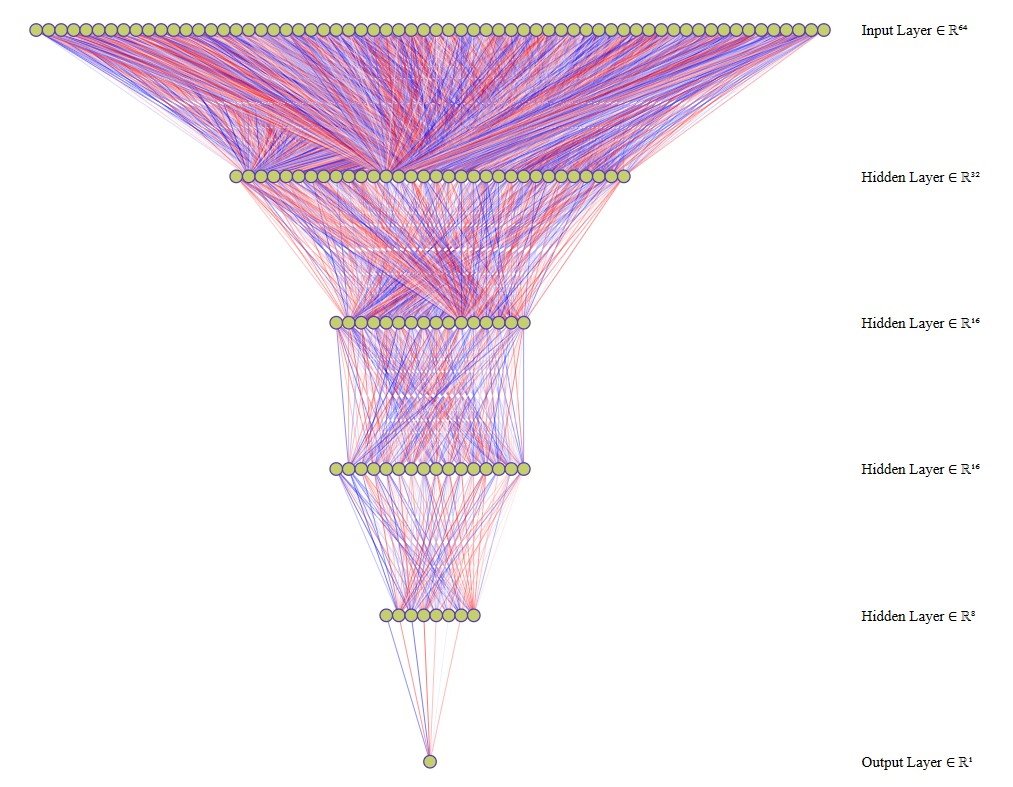

In [31]:
model.fit(X_train, y_train, epochs = 1000, batch_size = 32)

NameError: name 'X_train' is not defined

In [25]:
y_pred = model.predict(X_val)
y_pred = (y_pred > 0.4).astype('int64')
y_pred = y_pred.reshape(len(y_pred))    

NameError: name 'X_val' is not defined

In [26]:
print(classification_report(y_val, y_pred))

NameError: name 'y_val' is not defined

In [27]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_pred, y_val)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

NameError: name 'y_pred' is not defined

In [28]:
# visualize confusion matrix with seaborn heatmap
import seaborn as sns
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

NameError: name 'cm' is not defined

# LightGBM Model

In [ ]:
# build the lightgbm model
import lightgbm as lgb
clf = lgb.LGBMClassifier(boosting_type='dart', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=10, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=10, n_jobs=-1, num_leaves=31, objective='binary',
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=2000, subsample_freq=0, metric = 'auc')
clf.fit(X_train, y_train)

LGBMClassifier(boosting_type='dart', metric='auc', min_child_samples=10,
               n_estimators=10, objective='binary', silent=True,
               subsample_for_bin=2000)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(y_pred, y_val)
print('LightGBM Model accuracy score: {0:0.8f}'.format(accuracy_score(y_pred, y_val)))

LightGBM Model accuracy score: 0.73779904


In [ ]:
y_pred = clf.predict(X_train)

In [29]:
print('Training-set accuracy score: {0:0.8f}'. format(accuracy_score(y_train, y_pred)))

NameError: name 'y_train' is not defined

In [30]:
y_pred=clf.predict(X_val)

NameError: name 'X_val' is not defined

In [42]:
# print the scores on training and test set
print('Training set score: {:.8f}'.format(clf.score(X_train, y_train)))
print('Test set score: {:.8f}'.format(clf.score(X_val, y_val)))

Training set score: 0.76053640
Test set score: 0.69473684


In [43]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_pred, y_val)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[329 130]
 [189 397]]

True Positives(TP) =  329

True Negatives(TN) =  397

False Positives(FP) =  130

False Negatives(FN) =  189


<AxesSubplot:>

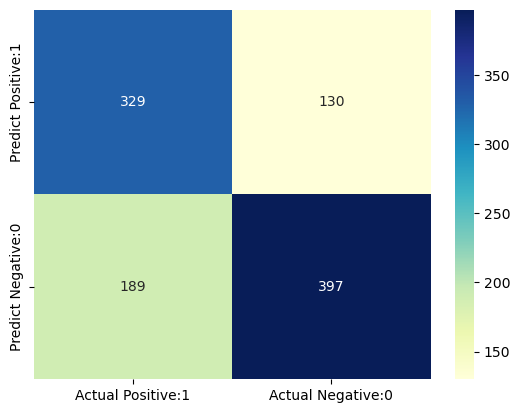

In [48]:
# visualize confusion matrix with seaborn heatmap
import seaborn as sns
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')